# MAIA Overview

This tutorial would introduce you on the usage of MAIA, a toolbox designed for processing and analysis of MALDI-MSI data. 

The whole pipeline of MAIA is consisted of 3 parts as the following figure suggests:


<div>
<center>
<img src="figs/MAIA workflow.png" width="800">
</center>
</div>

MAIA package is consisted of 3 main modules, namely <code>peak_finding (pf)</code>, <code>molecular_matcher (mm)</code> and <code>normalizer (norm)</code>. In addition to that there are two other modules to help with loading the data in different stages and visualization, namely <code>utils (ut)</code> and <code>visualize (vis)</code>.

In [11]:
import MAIA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

## Step 1: Image Extraction using adaptive Peak Finder

***MAIA*** identifies more molecules than other freely-available software, imaging them automatically with higher quality.

To load the raw data you need to specify the path to the **IBD** and **imzml** files, which contain the raw output of MALDI mass spectrometer and the correspoding metadata.

In [2]:
path_data = '/data/SV_DAngelo/Leila/MALDI-MSI/MAIA_zebrafish/Atlases/72hpf/Atlas_72hpf_fish2/'
path_save = '../MAIA/data'
name = '20220621_Zebrafish_atlas_72hpf_fish2_section_20_481x136_Att35_7um'

# create directories
MAIA.ut.tools.createSaveDirectory(path_save)
MAIA.ut.tools.createSaveDirectory(os.path.join(path_save, name))

smz = MAIA.ut.SmzMLobj(f'{os.path.join(path_data,name,name)}.IBD',
                           f'{os.path.join(path_data,name,name)}.imzml',
                           mz_resolution=10e-5)

smz.load(load_unique_mz=True)
smz.S

Directory at ../MAIA/data already exists
Directory at ../MAIA/data/20220621_Zebrafish_atlas_72hpf_fish2_section_20_481x136_Att35_7um already exists


Loading Spectra at resolution 0.0001: 100%|███████████████████████████████████████████████████████| 65418/65418 [00:09<00:00, 6967.24it/s]
Loading the m/z values at resolution 0.0001: 65418it [00:13, 4826.65it/s]
65418it [1:22:34, 13.20it/s]


<65418x4515715 sparse matrix of type '<class 'numpy.float64'>'
	with 82857857 stored elements in Compressed Sparse Column format>

You can visualize the raw frequencies of mass-to-charge ratios as well:

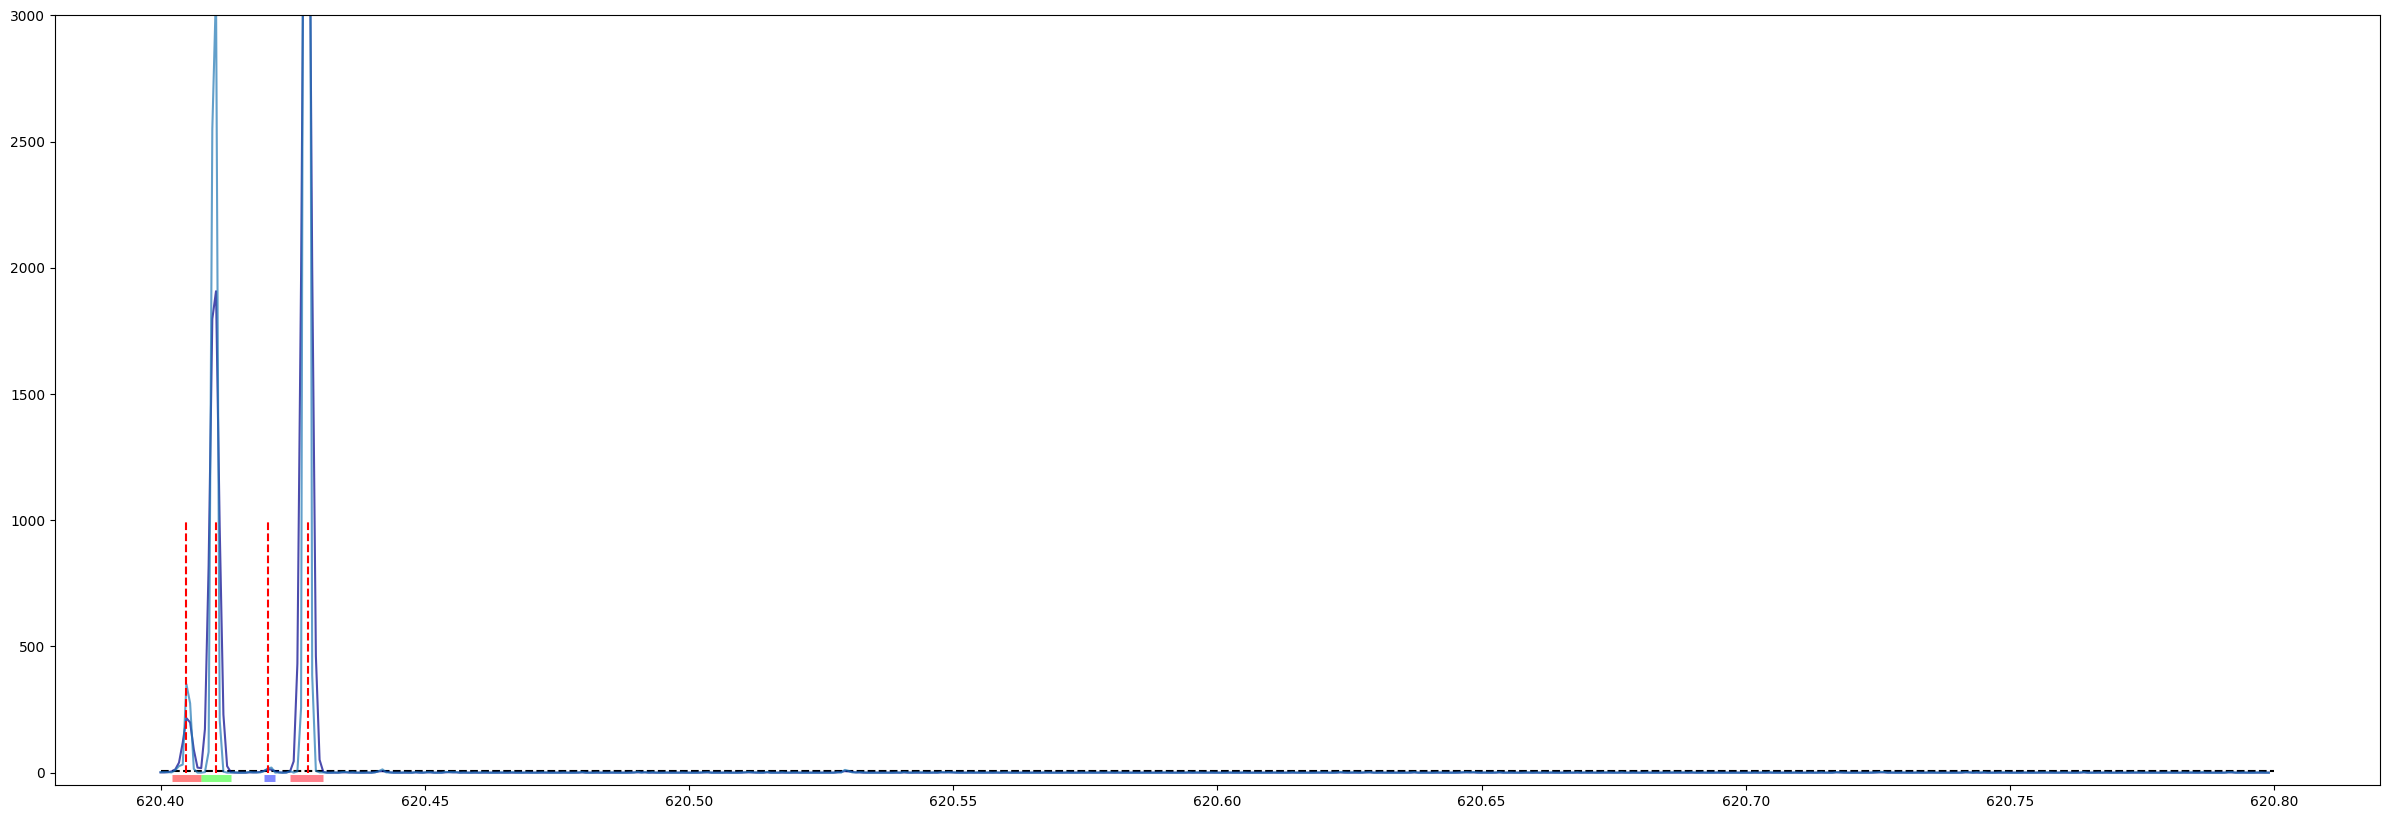

In [3]:
mz_resolution = 0.0001
threshold_count = 8.
approximate_interval =1.5
smoothing = 1. #2.5

mzrange_test = np.array([620.4,620.8])

PF = MAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=3000, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

To identify the molecules you need to run the MAIA peak finder by specifiying the corresponding hyperparameters.

The output of the peak finder are the <code>images.h5ad</code> and <code>ranges.csv</code> files, which are then saved in the specified directory path.

In [ ]:
MAIA.pf.run(directory_path=os.path.join(path_save, name),
            smz=smz, 
            spectrum_range=(400,1200),
            threshold_count=threshold_count, 
            approximate_interval=approximate_interval,
            smoothing=smoothing,
            parallelize=True,
            saveimages=True)

Partioning m/z space and beginning peakcalling...


  7%|███████▌                                                                                             | 8/107 [01:31<18:05, 10.97s/it]

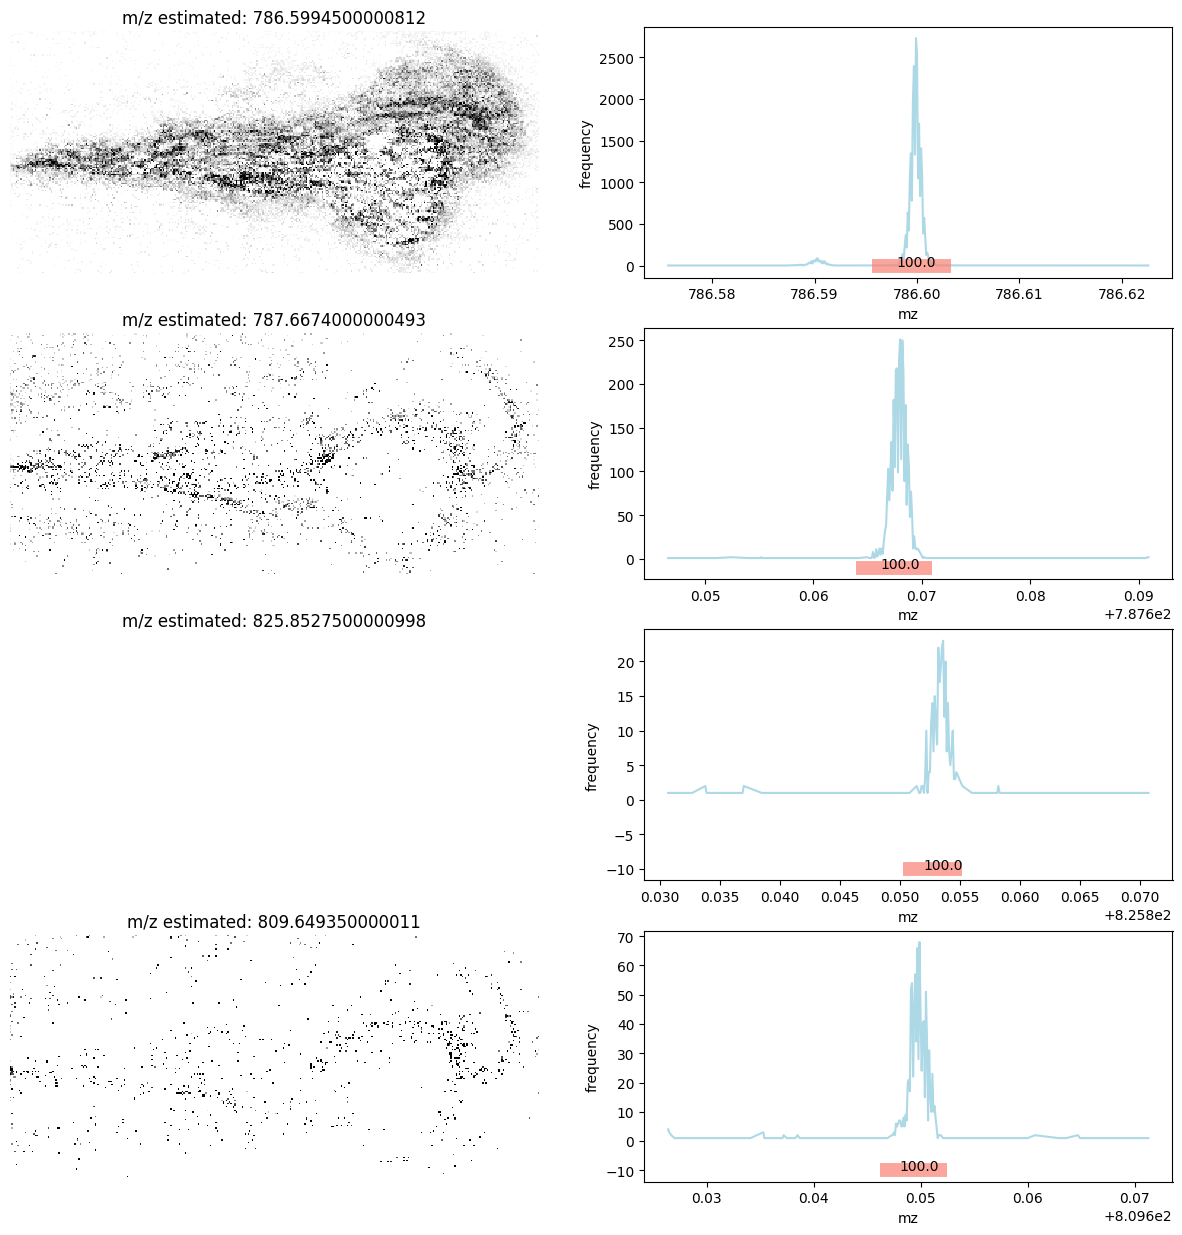

In [17]:
df_ranges = pd.read_csv(os.path.join(path_save, name, 'ranges.csv'), index_col=0)

# [478.329, 764.5201, 723.4935, 518.3217,806.5694, 764.5225,478.33]
adduct_H = 1.007
adduct_Na = 22.98977
adduct_K = 39.0983
adduct_NH4 = 14.0067 + 4 * adduct_H
s_mz =787.66876 - adduct_H


fig = MAIA.vis.image_mz(smz, df=df_ranges, 
                             mz_list=[s_mz, s_mz + adduct_H, s_mz + adduct_K, s_mz + adduct_Na], 
                             cmap='Greys',figsize=(15,15),
                             img_shape=smz.img_shape, limit=0.01,clip=99,
                            )

## Step 2: Molecule Matching

***MAIA*** retrieves identical molecules across acquistions without ambiguity.

In [2]:
acquisitions = [
    '20220705_Zebrafish_Atlas_72hpf_fish2_section_12_182x95_Att35_7um',
    '20220701_Zebrafish_atlas_72hpf_fish2_section_14_407x132_Att35_7um',
    '20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um',
    '20220702_Zebrafish_atlas_72hpf_fish2_section_18_452x136_Att35_7um',
    '20220621_Zebrafish_atlas_72hpf_fish2_section_20_481x136_Att35_7um', 
           ]

ranges_files = [os.path.join(path_save, name, 'ranges.csv') for name in acquisitions]
images_files = [os.path.join(path_save, name, 'images.h5ad') for name in acquisitions]


df_list = MAIA.ut.tools.read_files(ranges_files) # load files
df_list = MAIA.ut.tools.filterSparseImages(df_list) # filter sparse images (noise)

In [3]:
df_match = MAIA.mm.match(MAX_DIST=0.005, df_list=df_list)
# filter out molecules that we are not interested in imaging
df_filter = MAIA.mm.filter_matches(df_match, num_match=5) 
df_filter.sort_values(['molecule_ID', 'section_ix'], inplace=True)

print(f'Number of unique molecules after filtering: {len(df_filter.molecule_ID.value_counts())}')

  0%|                                                                                                             | 0/800 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12


 29%|████████████████████████████▊                                                                      | 233/800 [03:10<07:44,  1.22it/s]

[array([633.0079, 633.0227, 633.0327, 633.0479, 633.0581, 633.0682,
        633.0751, 633.0894, 633.1452, 633.1533, 633.1578, 633.1741,
        633.1941, 633.2152, 633.2232, 633.2274, 633.239 , 633.2446,
        633.2514, 633.26  , 633.2681, 633.2753, 633.2787, 633.2841,
        633.2869, 633.2965, 633.3076, 633.314 , 633.3204, 633.3225,
        633.3353, 633.3438, 633.3565, 633.3726, 633.3801, 633.395 ,
        633.4035, 633.4335, 633.4547, 633.8212, 633.9732, 633.9916])
 array([633.0076, 633.021 , 633.0321, 633.048 , 633.0579, 633.0682,
        633.0755, 633.1464, 633.1578, 633.1741, 633.2147, 633.2233,
        633.2296, 633.2391, 633.244 , 633.2512, 633.2598, 633.2683,
        633.2788, 633.2841, 633.2965, 633.3073, 633.3154, 633.3192,
        633.3331, 633.3449, 633.3515, 633.3566, 633.3728, 633.3804,
        633.395 , 633.403 , 633.4331, 633.5805, 633.9735])
 array([633.0072, 633.0213, 633.0321, 633.048 , 633.0578, 633.0698,
        633.2509, 633.2594, 633.2631, 633.2684, 633.296 



KeyboardInterrupt



In [ ]:
# save the images to zarr format
PATH_SAVE = os.path.join(path_save, 'TestStack.zarr')
MAIA.ut.tools.to_zarr(PATH_SAVE, acquisitions, df_filter, images_files)


In [ ]:
# visualize images
MAIA.vis.showMatchedImages(PATH_SAVE, [10,1,2], acquisitions, figsize=(10,5))

## Step 3: Normalization

***MAIA*** normalizes images by fitting a Bayesian model that accounts for different sources of noise in a regularized way and allows a conservative non-linear rescaling of intensity values such that qualifications can be properly compared across sections.

In [6]:
path_save = '../MAIA/data'
PATH_SAVE = os.path.join(path_save, 'TestStack.zarr')
# PATH_MASKS = '/data/SV_DAngelo/Hannah/zebrafish_masks'

In [8]:
acquisitions = [
    '20220705_Zebrafish_Atlas_72hpf_fish2_section_12_182x95_Att35_7um',
    '20220701_Zebrafish_atlas_72hpf_fish2_section_14_407x132_Att35_7um',
    '20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um',
    '20220702_Zebrafish_atlas_72hpf_fish2_section_18_452x136_Att35_7um',
    '20220621_Zebrafish_atlas_72hpf_fish2_section_20_481x136_Att35_7um', 
           ]

In [9]:
x, masks = MAIA.ut.tools.read_images_masks(acquisitions,
                                        path_images=PATH_SAVE, path_masks=None,
                                        gaussian_smoothing=True, gaussian_sigma=0.3,
                                        log_transform=True, epsilon=0.0002
                                       )

PathNotFoundError: nothing found at path ''

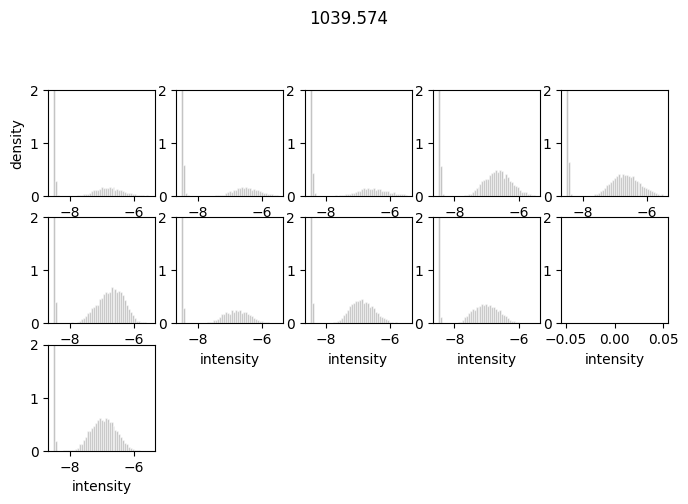

In [5]:
MAIA.vis.plot_intensity(x, masks, v=50, mz_val=None)

We can model the MALDI-MSI data intensities’ histogram as a gaussian mixture model and approximate the true foreground distribution, where the non-biological batch effects have been taken into account. To normalize the data, MAIA uses the following graphical model to address the batch effects.

<div>
<center>
<img src="figs/MAIA_PGM.png" width="800">
</center>
</div>

To initialize the SVI, we simply fit a GMM on the cumulative distribution of each molecule. We use BIC metric to choose whether a unimodal or bimodal gaussian distribution would fit the best on the intensities. It's also possible to intialize the required parameters manually and save them in a dictionary to pass for the normalization method.

In [17]:
init_state = MAIA.norm.initialize(x, masks, visualize=False, subsample=True)

GMM Initialization:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]

In [19]:
svi_result = MAIA.norm.normalize(x, 
                              masks,
                              #init_state=init_state,
                              subsample=True,
                              optimizer=None,
                              num_steps=5000,
                              seed=42)

GMM Initialization:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]

After normalization, you can save the parameters of interest using the utils module for further analysis.

In [8]:
SAVE_PATH = f'/home/alireza/parameters/{NAME_FOLDER}'
MAIA.ut.tools.save_svi(svi_result, SAVE_PATH)

Afterwards, you can transform your data to get the MAIA normalized MALDI-MSI data and preform future downstream analysis.

In [9]:
x_tran = MAIA.norm.transform(x, masks, svi_result)

You can visualize the raw intensities vs the normalized intensities and the fitted model in the same figure as well.

molecule susceptibility: 0.23


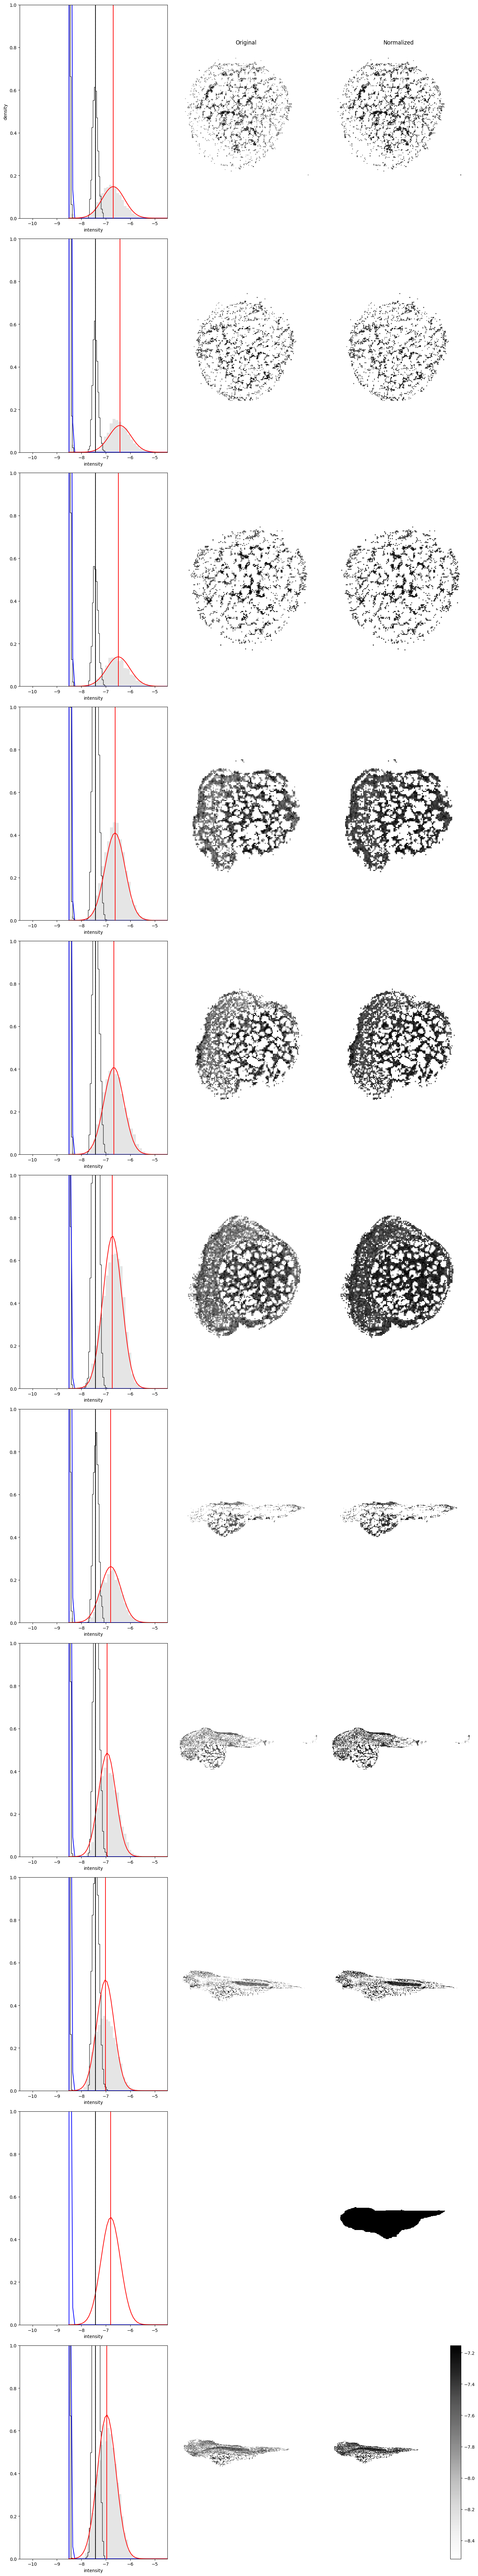

In [12]:
MAIA.vis.normalized_hist(x_tran, x, masks, svi_result, acquisitions, v=1)